
=== SSE Subspace Alignment Score: 0.4999 ===


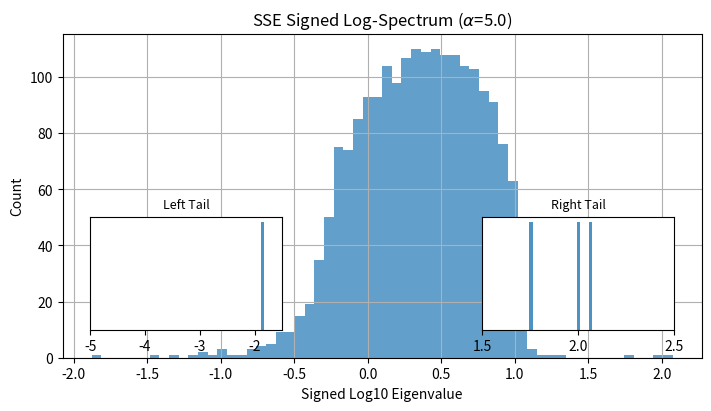

In [12]:
import torch
import numpy as np
import pandas as pd
from scipy.special import kv as besselk
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sns
from numpy.linalg import qr, norm
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ---------------------------
# Step 0. Parameter Config
# ---------------------------
n, p = 5000, 2
alpha, alpha_c = 5.0, 0.59375
d = int(n / alpha)
R = np.sqrt(alpha / alpha_c)
device = torch.device("cpu")

torch.manual_seed(42)
np.random.seed(42)

# ---------------------------
# Step 1. Generate Data
# ---------------------------
W_star = torch.nn.functional.normalize(torch.randn(d, p), dim=0)
X = torch.randn(n, d)
Z = X @ W_star
y = Z[:, 0] * Z[:, 1]
y_np = y.numpy()

# ---------------------------
# Step 2. Construct T(y)
# ---------------------------
def construct_T_y(y_i, gamma=1.0, clip=1e-2, scale=5.0):
    y_scaled = scale * y_i
    abs_y = np.abs(y_scaled) + 1e-8
    K0 = besselk(0, abs_y)
    K1 = besselk(1, abs_y)
    r = abs_y * (K1 / (K0 + 1e-6))
    r = np.clip(r, clip, None)
    return torch.tensor([[r, gamma * y_scaled],
                         [gamma * y_scaled, r]], dtype=torch.float32)

# ---------------------------
# Step 3. Build Spectral Matrix L_sym
# ---------------------------
I_p = torch.eye(p)                   # p×p (p=2)
L_sym = torch.zeros((2 * d, 2 * d))

for i in range(n):
    x_i = X[i].reshape(d, 1)
    kron_x = torch.kron(I_p, x_i)    # Kronecker (2d, p)
    T_yi = construct_T_y(y_np[i])
    L_sym += kron_x @ T_yi @ kron_x.T

L_sym /= n

# ---------------------------
# Step 4. Eigendecomposition
# ---------------------------
eigvals_sym, eigvecs_sym = torch.linalg.eigh(L_sym)
eigvals_np = eigvals_sym.numpy()
eigvecs_np = eigvecs_sym.numpy()

# ---------------------------
# Step 5. Subspace Alignment Score
# ---------------------------
def elevate_W_star_to_symmetric(W_star):
    return np.vstack([
        np.hstack([W_star, np.zeros_like(W_star)]),
        np.hstack([np.zeros_like(W_star), W_star])
    ])

U_top = eigvecs_sym[:, -p:]  # 前 p 条主特征向量
U_top_np = U_top.numpy()
W_sym_np = elevate_W_star_to_symmetric(W_star.numpy())

Q1, _ = qr(U_top_np)
Q2, _ = qr(W_sym_np)
overlap = Q1.T @ Q2
subspace_score = np.linalg.norm(overlap, 'fro')**2 / p

print(f"\n=== SSE Subspace Alignment Score: {subspace_score:.4f} ===")

# ---------------------------
# Step 6. Spectrum Visualization
# ---------------------------
log_signed = np.sign(eigvals_np) * np.log10(np.abs(eigvals_np) + 1e-12)
left_tail = log_signed[log_signed < -1.5]
right_tail = log_signed[log_signed > 1.5]

fig, ax = plt.subplots(figsize=(7, 4), constrained_layout=True)
ax.hist(log_signed, bins=60, alpha=0.7)
ax.set_title(f"SSE Signed Log-Spectrum ($\\alpha$={alpha:.1f})")
ax.set_xlabel("Signed Log10 Eigenvalue")
ax.set_ylabel("Count")
ax.grid(True)

# 左右尾部插图
ax_left = inset_axes(ax, width="30%", height="35%", loc='lower left', borderpad=2)
ax_left.hist(left_tail, bins=20, color='tab:blue', alpha=0.8)
ax_left.set_xlim(-5, -1.5)
ax_left.set_xticks([-5, -4, -3, -2])
ax_left.set_yticks([])
ax_left.set_title("Left Tail", fontsize=9)

ax_right = inset_axes(ax, width="30%", height="35%", loc='lower right', borderpad=2)
ax_right.hist(right_tail, bins=20, color='tab:blue', alpha=0.8)
ax_right.set_xlim(1.5, 2.5)
ax_right.set_xticks([1.5, 2.0, 2.5])
ax_right.set_yticks([])
ax_right.set_title("Right Tail", fontsize=9)

plt.show()





[Individual Eigenvector Alignment Scores]
      Type        λ  Alignment Score
0  eig1992  11.4846           0.0012
1  eig1993  11.6467           0.0154
2  eig1994  11.7092           0.0222
3  eig1995  11.7515           0.0703
4  eig1996  12.0398           0.0208
5  eig1997  12.4755           0.1567
6  eig1998  12.9617           0.2435
7  eig1999  14.3322           0.2571

[Eigenvector Pair Subspace Alignment Scores]
               Type                  λ Pair  Alignment Score
0   eig1992+eig1993  (11.484554, 11.646711)           0.0260
1   eig1992+eig1994  (11.484554, 11.709238)           0.0387
2   eig1992+eig1995  (11.484554, 11.751511)           0.0427
3   eig1992+eig1996  (11.484554, 12.039775)           0.0224
4   eig1992+eig1997    (11.484554, 12.4755)           0.0301
5   eig1992+eig1998   (11.484554, 12.96169)           0.3407
6   eig1992+eig1999  (11.484554, 14.332246)           0.3677
7   eig1993+eig1994  (11.646711, 11.709238)           0.0348
8   eig1993+eig1995  (11.6467

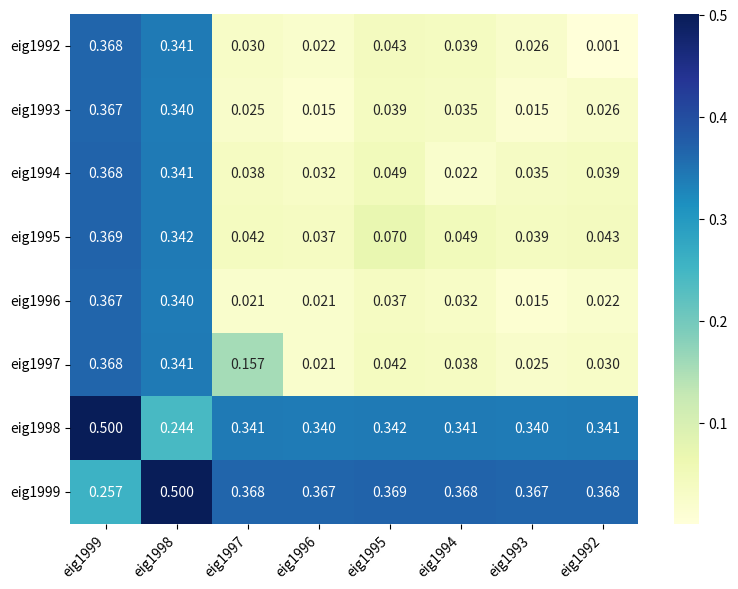

In [16]:
import numpy as np
import pandas as pd
import torch
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------
# Step 1. Elevation Helpers
# ----------------------------
def elevate_W_star_to_symmetric(W_star):
    """
    Elevate W_star ∈ R^{d×p} into symmetric 2d×p block representation.
    """
    return np.vstack([
        np.hstack([W_star, np.zeros_like(W_star)]),
        np.hstack([np.zeros_like(W_star), W_star])
    ])

def elevate_vector(v, position='top', d=None):
    """
    Elevate a d-dim vector into a 2d vector for symmetric alignment.
    """
    if d is None:
        d = v.shape[0]
    if position == 'top':
        return np.concatenate([v, np.zeros(d)])
    else:
        return np.concatenate([np.zeros(d), v])

# ----------------------------
# Step 2. Unified Evaluation
# ----------------------------
def evaluate_alignment_unified(eig_vals, eig_vecs, W_star, top_k=8, mode='symmetric'):
    """
    Unified evaluation for SSE:
    - Rank-1 alignment: each eigenvector vs true subspace
    - Rank-2 alignment: any pair of eigenvectors vs true subspace

    Parameters
    ----------
    eig_vals : np.ndarray, shape (2d,)
        Eigenvalues of SSE spectral matrix.
    eig_vecs : np.ndarray, shape (2d, 2d)
        Corresponding eigenvectors.
    W_star : torch.Tensor, shape (d, p)
        Ground truth signal subspace.
    top_k : int, default=8
        Number of leading eigenvectors to evaluate.
    mode : str, {'symmetric', 'asymmetric'}
        Elevation mode for subspace alignment.

    Returns
    -------
    individual_df : pd.DataFrame
        Rank-1 alignment scores.
    pair_df : pd.DataFrame
        Rank-2 alignment scores.
    """
    d, p = W_star.shape
    # Elevate true subspace into symmetric block form
    W_sym_np = elevate_W_star_to_symmetric(W_star.numpy())
    Q_true, _ = np.linalg.qr(W_sym_np[:, :p])

    # Select top-k eigenvectors
    indices = np.argsort(eig_vals)[-top_k:]

    # ---------- Rank-1 Alignment ----------
    individual_scores = []
    for i in indices:
        vec = eig_vecs[:, i]  # eigenvector shape: (2d,)
        try:
            # Reshape into d × 2 block representation
            V = vec.reshape(2, d).T  # shape: (d, 2)
        except:
            print(f"Error reshaping eigenvector {i}, shape = {vec.shape}")
            continue
        # Elevate estimated subspace
        W_est = elevate_W_star_to_symmetric(V)  # (2d, 2)
        Q_est, _ = np.linalg.qr(W_est)
        overlap = Q_est.T @ Q_true
        align_score = np.linalg.norm(overlap, 'fro')**2 / p
        individual_scores.append((f"eig{i}", eig_vals[i], align_score))

    # ---------- Rank-2 Alignment ----------
    pair_scores = []
    for i, j in combinations(indices, 2):
        vi = eig_vecs[:, i]
        vj = eig_vecs[:, j]
        # For asymmetric mode, elevate separately
        if mode == 'asymmetric':
            vi = elevate_vector(vi, 'top', d=d)
            vj = elevate_vector(vj, 'top', d=d)
        # Combine eigenvectors into candidate subspace
        V = np.stack([vi, vj], axis=1)  # shape: (2d, 2)
        Q, _ = np.linalg.qr(V)
        Q_torch = torch.tensor(Q, dtype=torch.float32)
        W_sym = torch.tensor(W_sym_np, dtype=torch.float32)
        proj = Q_torch @ Q_torch.T @ W_sym
        align_score = (torch.norm(proj) / torch.norm(W_sym)).item()
        pair_scores.append((f"eig{i}+eig{j}", (eig_vals[i], eig_vals[j]), align_score))

    individual_df = pd.DataFrame(individual_scores, columns=["Type", "λ", "Alignment Score"])
    pair_df = pd.DataFrame(pair_scores, columns=["Type", "λ Pair", "Alignment Score"])
    return individual_df, pair_df

# ----------------------------
# Step 3. Heatmap Visualization
# ----------------------------
def plot_alignment_heatmap(pair_df, individual_df):
    """
    Heatmap visualization for unified SSE evaluation.

    Rows = eigX (ascending order), Columns = eigX (descending order).
    Diagonal = Rank-1 scores, Off-diagonals = Rank-2 scores.
    """
    # Extract unique eigenvector labels
    labels = sorted(set([t.split('+')[0] for t in pair_df['Type']] + 
                        [t.split('+')[1] for t in pair_df['Type']]))

    # Initialize symmetric matrix
    heatmap_df = pd.DataFrame(np.nan, index=labels, columns=labels)

    # Fill off-diagonals with Rank-2 scores
    for _, row in pair_df.iterrows():
        e1, e2 = row["Type"].split("+")
        heatmap_df.loc[e1, e2] = row["Alignment Score"]
        heatmap_df.loc[e2, e1] = row["Alignment Score"]

    # Fill diagonals with Rank-1 scores
    for idx in labels:
        value = individual_df[individual_df["Type"] == idx]["Alignment Score"].values[0]
        heatmap_df.loc[idx, idx] = value

    # Reverse x-axis order for symmetry
    reversed_cols = labels[::-1]

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        heatmap_df.loc[:, reversed_cols].astype(float),
        annot=True, fmt=".3f", cmap="YlGnBu", cbar=True,
        xticklabels=reversed_cols, yticklabels=labels
    )

    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return heatmap_df

# ----------------------------
# Step 4. Run Unified Evaluation
# ----------------------------
eigvals_np = eigvals_sym.numpy()
eigvecs_np = eigvecs_sym.numpy()

individual_df, pair_df = evaluate_alignment_unified(
    eigvals_np, eigvecs_np, W_star, top_k=8, mode='symmetric'
)

print("\n[Individual Eigenvector Alignment Scores]")
print(individual_df.round(4))
print("\n[Eigenvector Pair Subspace Alignment Scores]")
print(pair_df.round(4))

# Draw alignment heatmap
heatmap_df = plot_alignment_heatmap(pair_df, individual_df)

